# 📜 Previsões das cores de Cartas Magic - 2 Fase: StopWords; TF-IDF; Naive Bayes; Logistic Regression 🌊🧙‍♂️⚔️🌳

## Importar Bibliotecas

### Bibliotecas necessárias para a utilização do notebook

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sys
import math
import sklearn
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

nltk.download('stopwords')
nltk.download('punkt')



[nltk_data] Downloading package stopwords to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Regex

In [128]:
df = pd.read_csv("datasets/cleaner_data.csv")
print(df.size)
df.head()

88767


,Unnamed: 0,name,multiverse_id,color_identity,text,flavor,power
0,1,Ancestor's Chosen,NaN,['W'],First strike (This creature deals combat damag...,"""The will of all, by my hand done.""",4
1,2,Angel of Mercy,129465.0,['W'],Flying\r\nWhen Angel of Mercy enters the battl...,Every tear shed is a drop of immortality.,3
2,4,Angelic Blessing,129711.0,['W'],Target creature gets +3/+3 and gains flying un...,Only the warrior who can admit mortal weakness...,NaN
3,6,Angelic Chorus,129710.0,['W'],Whenever a creature enters the battlefield und...,The harmony of the glorious is a dirge to the ...,NaN
4,7,Angelic Wall,129671.0,['W'],Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't beg...",0


### **Função: `clean_color`**

As cartas de *Magic: The Gathering* são divididas em várias categorias de **cores**. Algumas cartas possuem combinações de:
- **Duas cores** (ex.: Branco-Verde, Verde-Azul).  
- **Três ou mais cores**.

No entanto, a complexidade e diversidade dessas combinações de cores exigem:
1. **Maior poder de computação**.  
2. **Modelos mais robustos e avançados** para análise.


#### **Objetivo da Função**  
A função `clean_color` **filtra** as cartas, restringindo o foco para aquelas com **apenas um único tipo de cor**.  

Esta abordagem proporciona:  
- Uma análise **mais precisa e controlada**.  
- Maior **eficiência computacional**.  
- Redução da complexidade na interpretação dos resultados.



In [129]:
def clean_color(text):
    # as cores são branco(W), preto(B), azul(U), vermelho(R) ou verde(G)
    pattern = r"\['(W|B|U|R|G)'\]"
    
    match = re.search(pattern, text)
    
    if match:
        return match.group(1)
    return None

df["color"] = df["color_identity"].apply(clean_color)
df.drop("color_identity", axis=1, inplace = True)

In [130]:
df["color"].value_counts()

color
W    2632
R    2575
B    2563
G    2475
U    2436
Name: count, dtype: int64

## Análise da coluna Text em cartas de *Magic: The Gathering* com Regex

Este código aplica **técnicas de *text mining*** para identificar e categorizar mecânicas específicas em cartas de *Magic: The Gathering*. A análise utiliza **expressões regulares** (regex) para pesquisar palavras-chave e padrões dentro do texto das cartas e, assim, atribuir valores **True/False** a diferentes colunas do DataFrame `df`.

Cada coluna representa uma mecânica ou habilidade específica do jogo. Abaixo está uma explicação detalhada das colunas e dos padrões utilizados:


### 1. **Anulações (`counterspell`)**  
Identifica cartas que anulam feitiços ou habilidades:  
- Padrões: `counter target`, `counter all`  
- Exclui a mecânica **Ward**, que é mais transversal.  


### 2. **Exílio (`exile`)**  
Procura cartas que exilam permanentes do tabuleiro:  
- Padrões: `exile target`, `exile each`, etc.  
- Ignora cartas que exilam do **topo do deck**.



### 3. **Luta (`fight`)**  
Identifica cartas que contêm a palavra `fights`, uma mecânica característica do **verde**.



### 4. **Mill (`mill`)**  
Procura a palavra-chave `mill`.  
> *Nota*: Cartas antigas referem-se a esta mecânica como "descartar cartas do topo do baralho" (*a adicionar futuramente*).



### 5. **Scry (`scry`)**  
Identifica cartas que contêm a palavra `scry`.



### 6. **Tap e Untap (`tap` e `untap`)**  
- **Tap**: Captura cartas que giram permanentes com padrões como `tap target`.  
- **Untap**: Procura cartas que desviram permanentes com padrões como `untap each`.



### 7. **Double Strike e First Strike (`double_strike` e `first_strike`)**  
Identifica cartas com estas habilidades de combate.



### 8. **Flash (`flash`)**  
Captura cartas com a habilidade `flash`:  
- Exclui referências à mecânica **flashback**.


### 9. **Flying (`flying`)**  
Identifica cartas que contêm a habilidade `flying`.


### 10. **Haste (`haste`)**  
Procura cartas com a palavra `haste`.


### 11. **Hexproof (`hexproof`)**  
Detecta cartas com a habilidade **Hexproof**.


### 12. **Indestrutível (`indestructible`)**  
Identifica cartas com a palavra `indestructible`, ignorando textos que indiquem **perda** da habilidade.


### 13. **Sacrificar (`sacrifice`)**  
Procura cartas com a mecânica de **sacrificar** permanentes.


### 14. **Lifelink (`lifelink`)**  
Identifica cartas que contêm a palavra `lifelink`.


### 15. **Menace (`menace`)**  
Procura cartas com a habilidade `menace`.


### 16. **Proteção (`protection`)**  
Captura cartas com padrões como `protection from`.


### 17. **Prowess (`prowess`)**  
Identifica cartas com a palavra `prowess`.


### 18. **Reach (`reach`)**  
Procura cartas com a habilidade `reach`:  
- Exclui textos explicativos sobre **flying**.



### 19. **Trample (`trample`)**  
Detecta cartas com a habilidade **trample**.


### 20. **Vigilância (`vigilance`)**  
Identifica cartas com a palavra `vigilance`.


### 21. **Comprar e Descarta (`draw` e `discard`)**  
- **Draw**: Captura cartas que permitem **comprar** cartas.  
- **Discard**: Procura cartas com a palavra `discard`.



### 22. **Dano e Prevenção de Dano (`damage` e `damage_prevention`)**  
- **Damage**: Identifica cartas que causam dano (`deals X damage`).  
- **Damage Prevention**: Procura cartas com o texto `prevent`.


### 23. **Ganho e Perda de Vida (`life_gain` e `life_loss`)**  
- **Life Gain**: Procura cartas que permitem **ganhar vida**.  
- **Life Loss**: Captura cartas que causam **perda de vida** com valores fixos ou relativos.


### 24. **Criação de Tokens (`tokens`)**  
Identifica cartas que geram fichas com o padrão `create`.



### 25. **Destruição e Recursão (`destroy` e `recursion`)**  
- **Destroy**: Procura cartas que destroem permanentes.  
  - Exclui textos sobre **indestrutibilidade**.  
- **Recursion**: Captura cartas que devolvem permanentes do **cemitério** para a mão ou campo de batalha.



### 26. **Devolução (`return`)**  
Procura cartas que devolvem permanentes à **mão** ou **biblioteca** do jogador:  
- Exclui efeitos de **recursão** do cemitério.



In [131]:
df["counterspell"] = (df.text.str.contains(r"[Cc]ounter\s(?:it|target|all)") & # anulações
         (df.text.str.contains(r"[wW]ard(?:\s{|—])") == False)) # Ward é uma maneira de anulação/proteção mais transversal às cores e é ignorada


df["exile"] = (df.text.str.contains(r"[eE]xile\s(?:target|each|all|the|up\sto)") & # exilar algo do tablueiro
        (df.text.str.contains(r"the\stop") == False)) # Algumas cartas "compram" cartas exilando-as do topo do deck, isso nào conta como exilar algo do tabuleiro

df["fight"] = (df.text.str.contains(r"[Ff]ights")) # Criaturas lutarem é uma mecânica característica do verde


df["mill"] = (df.text.str.contains(r"[mM]ill")) # TODO: mill é uma palavra chave recente, antes era referida por descartar a carta do >TOPO DO BATALHO<, bom adicionar este texto também


df["scry"] = (df.text.str.contains(r"[sS]cry"))


df["tap"] = (df.text.str.contains(r"(?:\st|T)ap\s(?:it|target|each|all|or\suntap)")) # cartas que viram outras 


df["untap"] = (df.text.str.contains(r"[uU]ntap\s(?:it|target|each|all)")) # find untappers

"""
df.loc[df.text.str.contains("[dD]eathtouch") | # find creatures that have deathtouch
        df.text.str.contains("deals combat damage to a creature, destroy that creature", regex = False)] # or that have "derptouch"
"""

df["double_strike"] = (df.text.str.contains(r"[dD]ouble\sstrike"))


df["first_strike"] = (df.text.str.contains(r"[fF]irst\sstrike"))


df["flash"] = (df.text.str.contains(r"(?:f|\nF|^F)lash") & # some engineering to avoid incorrectly grabbing cards with Flash in the name
        (df.text.str.contains(r"[fF]lashback") == False)) # dont' want to capture flashback


df["flying"] = (df.text.str.contains(r"[fF]lying"))


df["haste"] = (df.text.str.contains(r"[hH]aste"))


df["hexproof"] = (df.text.str.contains(r"[hH]exproof"))


df["indestructible"] = (df.text.str.contains(r"[iI]ndestructible") &
                         (df.text.str.contains(r"loses\sindestructible") == False))


df["sacrifice"] = (df.text.str.contains(r"[sS]acrifice"))


df["lifelink"] = (df.text.str.contains(r"[lL]ifelink"))


df["menace"] = (df.text.str.contains(r"[mM]enace"))


df["protection"] = (df.text.str.contains(r"[pP]rotection\sfrom"))


df["prowess"] = (df.text.str.contains(r"[pP]rowess"))


df["reach"] = (df.text.str.contains(r"(?:\sr|\nR|^R)each") &
        (df.text.str.contains(r"can't be blocked except by creatures with flying or reach", regex = False) == False)) # don't want flying reminder text


df["trample"] = (df.text.str.contains(r"[tT]rample"))


df["vigilance"] = (df.text.str.contains(r"[vV]igilance"))


df["draw"] = (df.text.str.contains(r"(?:\sd|\nD|^D)raw"))


df["discard"] = (df.text.str.contains(r"[dD]iscard"))


df["damage"] = (df.text.str.contains(r"deals\s\d\sdamage"))


df["damage_prevention"] = (df.text.str.contains(r"[pP]revent\s"))


df["life_gain"] = (df.text.str.contains(r"gain(?:\s|s\s)\d+\slife"))


df["life_loss"] = (df.text.str.contains(r"loses") & 
                   df.text.str.contains(r"(?:their|\d+)\slife")) # capture both fixed and rational values


df["tokens"] = (df.text.str.contains(r"[cC]reate"))


df["destroy"] = (df.text.str.contains(r"[dD]estroy") &
                  (df.text.str.contains(r"don't\sdestroy\sit.") == False)) # reject indestructible's reminder text


df["return"] = (df.text.str.contains(r"[rR]eturn") &
        df.text.str.contains(r"owner's\s(?:hand|library)") & # capture hand or library bounce effects
        (df.text.str.contains(r"graveyard\sto") == False)) # exclude grave recursion


df["recursion"] = (df.text.str.contains(r"\sput|return") &
        df.text.str.contains(r"graveyard")&
        df.text.str.contains(r"hand|battlefield"))

In [132]:
df.head()

,Unnamed: 0,name,multiverse_id,text,flavor,power,color,counterspell,exile,fight,...,draw,discard,damage,damage_prevention,life_gain,life_loss,tokens,destroy,return,recursion
0,1,Ancestor's Chosen,NaN,First strike (This creature deals combat damag...,"""The will of all, by my hand done.""",4,W,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,2,Angel of Mercy,129465.0,Flying\r\nWhen Angel of Mercy enters the battl...,Every tear shed is a drop of immortality.,3,W,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,4,Angelic Blessing,129711.0,Target creature gets +3/+3 and gains flying un...,Only the warrior who can admit mortal weakness...,NaN,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,6,Angelic Chorus,129710.0,Whenever a creature enters the battlefield und...,The harmony of the glorious is a dirge to the ...,NaN,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7,Angelic Wall,129671.0,Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't beg...",0,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## STOP WORDS

### **Função: `remove_reminder_text`**

Esta função é utilizada para **limpar o texto de regras** de cartas de *Magic: The Gathering*, removendo informações que estão entre parênteses. Essas informações, conhecidas como **texto de lembrete**, podem referir mecânicas diferentes e criar confusões na análise.

#### **Objetivo**  
- **Remover textos entre parênteses**: Evitar que lembretes de regras causem ruído na análise.
- **Lidar com valores nulos**: Substituir valores nulos por uma string vazia.
- **Uniformizar texto**: Converter tudo para **minúsculas** e remover espaços extras.


In [133]:
def remove_reminder_text_and_mana_costs(text):
    if not isinstance(text, str):
        return ""  # alguns valores nulos, cartas sem texto de regra (costumam não ser muito jogadas mas existem)
    # Remove tudo o que está entre parentesis
    # São lembretes de regra para facilitar o jogo, mas que podem referir outras mecanicas diferentes e confundir 
    text_no_parentheses = re.sub(r'\(.*?\)', '', text)
    # Remove o custo de mana de algumas habilidades ativáveis nas cartas
    text_no_costs = re.sub(r"\{.*?\}",'',text_no_parentheses)
    # Devolve o texto em lower case
    return text_no_costs.strip().lower()

df["text"] = df["text"].apply(remove_reminder_text_and_mana_costs)

df["text"]

0        first strike \r\nwhen ancestor's chosen enters...
1        flying\r\nwhen angel of mercy enters the battl...
2        target creature gets +3/+3 and gains flying un...
3        whenever a creature enters the battlefield und...
4                                      defender \r\nflying
                               ...                        
12676    trample\r\nlandfall — whenever a land enters t...
12677    when turntimber ascetic enters the battlefield...
12678              put a +1/+1 counter on target creature.
12679    veteran adventurer is also a cleric, rogue, wa...
12680    the first kicked spell you cast each turn cost...
Name: text, Length: 12681, dtype: object

### **Função: `remove_punctuation`**

#### **Objetivo**  
Remover a **pontuação** de uma lista de frases, preservando apenas os caracteres alfabéticos e espaços.


In [134]:
def remove_punctuation(sentences):
    sentences_without_punctuation = [
        re.sub(r'[^a-zA-Zà-úÀ-Úâ-ûÂ-ÛãõÃÕáéíóúÁÉÍÓÚçÇüÜ ]+', '', sentence) for sentence in sentences
    ]
    return sentences_without_punctuation

### **Função: `remove_non_letter_words`**

#### **Objetivo**  
Remover palavras do texto que contenham **números**, **caracteres especiais** ou **letras repetidas** excessivamente (como em onomatopéias), deixando apenas palavras compostas por letras únicas e válidas.


In [135]:
def remove_non_letter_words(text):
    # split do texto
    words = text.split()
    # retira tudo que contém números e caracteres especiais (são sejam letras) e também retira palavras com letras repetidas (algumas onomatopéias como "aaaaahhhh")
    clean_words = [word for word in words if re.search(r'[a-zA-Z]', word)  and not re.search(r'(.)\1{2,}', word)] 
    return ' '.join(clean_words)

df['flavor'] = df['flavor'].apply(remove_non_letter_words)

In [136]:
'''
print("\nColunas e valores únicos:")
for coluna in df.columns:
    print(f"\nColuna: {coluna}")
    print(df[coluna].unique())
'''

'\nprint("\nColunas e valores únicos:")\nfor coluna in df.columns:\n    print(f"\nColuna: {coluna}")\n    print(df[coluna].unique())\n'

In [137]:
#print(df.dtypes)

**Objetivo**  
Preencher valores nulos na coluna `text` com uma string vazia e criar uma nova coluna `all_Text` que combina os textos das colunas `text` e `flavor`.


In [138]:
df['text'] = df['text'].fillna('')
df['all_Text'] = df['text'] + ' ' + df['flavor']
#print(df[['text', 'flavor', 'all_Text']])

### **Função: Pré-processamento de Texto para Previsão de Cores**

#### **Objetivo**  
A função `preprocess` é responsável por realizar o pré-processamento de texto, tornando-o mais adequado para o modelo de previsão de cores. O pré-processamento envolve a eliminação de stop words.


In [139]:
df["flavor"] = df["flavor"].astype(str)  #meter os valores em str (algum poderia estar em numero, float, etc) - tendo em conta que flavor = object

#stop words tendo em conta a biblioteca NLTK (Natural Language Toolkit) English
stop_words = set(stopwords.words("english")) 

stop_words.update(["one", "never", "even", "every", "see"])  #stopwords que observamos durante a visualização dos dados que aparecia em todas as cores em grandes quantidades

In [140]:
def preprocess(text, stop_words): #fazemos o processamento de cada palavra de forma a ficar mais "pronta" para ser utilizada no processo de prever as cores
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]#retirada de todas as stopwords
    return filtered_tokens

#ONDE MUDAMOS O TIPO DE PREVISAO E A COLUNA ESCOLHIDA PARA PROCESSAR TEXTOS

#df["processed_flavor"] = df["flavor"].apply(lambda x: preprocess(x, stop_words)) #um lambda para utilizar a função preprocess em cada frase da coluna "processed_flavor"
df["processed_flavor"] = df["all_Text"].apply(lambda x: preprocess(x, stop_words)) #um lambda para utilizar a função preprocess em cada frase da coluna "processed_flavor"
#df["processed_flavor"] = df["text"].apply(lambda x: preprocess(x, stop_words)) #um lambda para utilizar a função preprocess em cada frase da coluna "processed_flavor"

#print(df["processed_flavor"])

## TF IDF 

# FALTA ESCREVER A INTRO DO TF IDF

#### **Objetivo**
Após o pré-processamento, a coluna `processed_flavor` contém listas de palavras (tokens) que foram extraídas após a remoção de stop words. Para realizar a transformação de frequência de termos (TF-IDF) ou outras análises de texto, é necessário reagregar essas palavras de volta em uma string única.


In [141]:
df['processed_flavor'] = df['processed_flavor'].apply(lambda x: ' '.join(x)) #como o processed flavor vinha numa lista 
#(por culpa do processamento de retirada de stop words), houve a necessidade de voltar a juntar as palavras numa frase para se processeder a realização do TF IDF

#### **Objetivo**
O objetivo desta etapa é preparar os dados para a previsão das cores, criando os conjuntos de treino e teste, e usando a transformação TF-IDF para representar o texto de forma numérica. O foco é avaliar a capacidade do modelo de fazer previsões sobre dados que nunca foram vistos antes, ou seja, novas frases de cartas "inexistentes"

In [142]:
X = df #todos os dados, mas o que nos queremos será o processed_Flavor
y = df['color'] #cor

df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#inicialmente, para vermos como as previsões estão a funcionar, houve a necessidade de fazer tambem a tabela do TF IDF só com o dataset de treino de forma a
#ver realmente como se comporta a previsão do tf idf com novos dados
#se o tfidf tivesse utilizado os dados todos das cartas, nao tinhamos dados para testar as previsões
#posteriormente decidimos acrescentar o resto das cartas para ter o dataset de previsão final utilizado para prever cartas novas e as suas cores
#quando utilizamos o data set todo, e pegamos em cartas ja existentes, a previsão chega a 0.70% o que é natural porque a frase ja existe dentro da tabela, o que nos queremos
#é ver como se comporta com frases que a mesma nunca teve interação mas que ja teve interação com palavras de outras frases

In [143]:
#de forma a termos os documentos como as cores, tivemos de juntar todas as cores em uma cor unica, as, imaginemos, 300 linhas com cor azul, passa a ser 1 linha de cor azul com as varias palavras que essa cor conteve
df_grouped = df_train.groupby('color')['processed_flavor'].apply(lambda x: ' '.join(x)).reset_index()

#Iniciamos o TfidfVectorizer e ajustamos consoante os textos agrupados por cor
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_grouped['processed_flavor'])

#Pegar na matriz do TFIDF e passar para dataframe, de forma a tornar mais facil utilizar e vizualizar os dados
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df_grouped['color']
)

In [144]:
#queria meter uma tabela de 1D onde so mostra o valor de tfidf com maior valor de uma cor e certa palavra
tfidf_data = tfidf_df.stack().reset_index()
tfidf_data.columns = ['color', 'word', 'tfidf']
#ordenar os dados para ver o Top 20 
top_tfidf_all = tfidf_data.sort_values(by='tfidf', ascending=False).head(20)
print(top_tfidf_all)

      color      word     tfidf
3282      B  creature  0.557686
21189     G  creature  0.532488
74910     W  creature  0.513065
39096     R  creature  0.443166
69296     U    target  0.413507
57003     U  creature  0.388567
51389     R    target  0.379024
39317     R    damage  0.359448
15575     B    target  0.352685
87203     W    target  0.347681
52219     R      turn  0.302802
39435     R     deals  0.301553
55895     U      card  0.294293
74699     W   control  0.290831
33482     G    target  0.283421
88033     W      turn  0.281434
34312     G      turn  0.269780
20978     G   control  0.268265
8971      B      life  0.257297
2174      B      card  0.250185


In [145]:
#agora queriamos ver os valores dessas mesmas palavras mas para todas as cores

#As 20 palavras mais "importantes"
top_20_words = top_tfidf_all['word'].unique()
filtered_tfidf = tfidf_df[top_20_words]
top_20_tfidf = filtered_tfidf.loc[df['color'].unique()]
print(top_20_tfidf)

       creature    target    damage      turn     deals      card   control  \
color                                                                         
W      0.513065  0.347681  0.127326  0.281434  0.034768  0.118400  0.290831   
U      0.388567  0.413507  0.037410  0.177573  0.030926  0.294293  0.220969   
B      0.557686  0.352685  0.068194  0.211276  0.049786  0.250185  0.136807   
R      0.443166  0.379024  0.359448  0.302802  0.301553  0.104960  0.182431   
G      0.532488  0.283421  0.069719  0.269780  0.037891  0.193494  0.268265   

           life  
color            
W      0.160215  
U      0.020950  
B      0.257297  
R      0.020409  
G      0.109630  


In [146]:
#número máximo de linhas a serem exibidas
pd.set_option('display.max_rows', 1000)  

#tabela para o top 50 de cada cor
top_50_per_color = pd.DataFrame()
top_tfidf_all = tfidf_data.sort_values(by='tfidf', ascending=False)

#top 50 palavras de cada cor
for color in tfidf_data['color'].unique():
    top_50_color = top_tfidf_all[top_tfidf_all['color'] == color].head(100)
    top_50_per_color = pd.concat([top_50_per_color, top_50_color])
    
print(top_50_per_color)


      color            word     tfidf
3282      B        creature  0.557686
15575     B          target  0.352685
8971      B            life  0.257297
2174      B            card  0.250185
16405     B            turn  0.211276
11477     B          player  0.183246
4798      B             end  0.178644
1251      B     battlefield  0.165256
3071      B         control  0.136807
6602      B       graveyard  0.135133
6272      B            gets  0.132623
2176      B           cards  0.128439
10753     B        opponent  0.123419
13201     B       sacrifice  0.111705
6886      B            hand  0.110449
4881      B          enters  0.108358
5793      B          flying  0.096643
3889      B         destroy  0.094551
3283      B       creatures  0.083674
9165      B           loses  0.079072
4052      B        discards  0.077165
6121      B            gain  0.070286
3503      B          damage  0.068194
12802     B          return  0.067776
3629      B           death  0.064847
1330      B 

In [147]:
#Reverter ao formato original de tfidf_df
pivot_tfidf = top_50_per_color.pivot(index='color', columns='word', values='tfidf')
#Preencher valores ausentes com 0 
pivot_tfidf = pivot_tfidf.fillna(0)
print(pivot_tfidf)

word    ability      able  activate       add  additional     angel    argoth  \
color                                                                           
B      0.000000  0.000000  0.025521  0.023429    0.020918  0.000000  0.000000   
G      0.000000  0.000000  0.022229  0.067192    0.000000  0.000000  0.019084   
R      0.000000  0.020825  0.000000  0.026240    0.020409  0.000000  0.000000   
U      0.023444  0.000000  0.017458  0.000000    0.000000  0.000000  0.000000   
W      0.000000  0.000000  0.000000  0.000000    0.000000  0.025553  0.000000   

word   artifact    attack  attacking  ...        ve  viashino  vigilance  \
color                                 ...                                  
B      0.032633  0.000000   0.000000  ...  0.000000  0.000000   0.000000   
G      0.046984  0.000000   0.000000  ...  0.000000  0.000000   0.022698   
R      0.059977  0.019992   0.022908  ...  0.019159  0.021156   0.000000   
U      0.062350  0.019453   0.000000  ...  0.023444 

In [148]:
#palavras a serem retiradas, a ideia é ver se existe palavras que tem a mesma importancia, ou parecida em todas as cores 
words_to_remove = []

for word in tfidf_df.columns:
    max_value = tfidf_df[word].max()
    intervalo = max_value / 4
    #calculamos o intervalor entre o max_value e os valores perto do mesmo, se nas outras cores a 
    #importancia tiver perto logo a palavra não é importante so para uma cor mas para varias, podendo nao ajudar na previsao das cores no futuro
    if all(tfidf_df[word].drop(index=tfidf_df[word].idxmax()) > max_value - intervalo): #excluimos o max_value da palavra atual durante a comparação
        words_to_remove.append(word)
# Remover as palavras identificadas
filtered_tfidf_df = tfidf_df.drop(columns=words_to_remove)

In [149]:
def remove_words(text, words_to_remove):
    #passar a palavras
    words = text.split()
    #remover as palavras que estão na lista 'words_to_remove'
    filtered_words = [word for word in words if word.lower() not in words_to_remove]
    #Junta as palavras restantes de volta em uma frase
    return ' '.join(filtered_words)
            
words_to_remove.append('color')
#para removermos as palavras anteriores tambem no proprio df
df_train['processed_flavor'] = df_train['processed_flavor'].apply(lambda x: remove_words(x, words_to_remove))
print("Palavras removidas:", words_to_remove)

Palavras removidas: ['abandoned', 'bottle', 'callapheia', 'city', 'contained', 'content', 'designs', 'diamond', 'districts', 'eating', 'far', 'form', 'helping', 'keeping', 'let', 'list', 'permission', 'psemilla', 'resting', 'send', 'shred', 'stickered', 'stops', 'think', 'urza', 'wore', 'color']


In [150]:
all_words = []
for message in df['processed_flavor']:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

Number of words: 24861
Most common words: [('.', 31602), (',', 19443), ('``', 12795), ('creature', 6685), ('target', 4864), ("'s", 3927), ('turn', 3337), (':', 3057), ('control', 2965), ('card', 2629), ('end', 2472), ('The', 2455), ('battlefield', 2357), ('damage', 1901), ("n't", 1875)]


In [151]:
print(df['color'].value_counts())

color
W    2632
R    2575
B    2563
G    2475
U    2436
Name: count, dtype: int64


In [152]:
print(filtered_tfidf_df)

             10        11     115th        13       136        1½        20  \
color                                                                         
B      0.003347  0.001756  0.000878  0.001979  0.000000  0.000000  0.000000   
G      0.004547  0.000000  0.000000  0.000000  0.000000  0.000000  0.001711   
R      0.001666  0.000000  0.000000  0.000985  0.000000  0.001748  0.002116   
U      0.001496  0.000000  0.000000  0.000590  0.000000  0.000000  0.000000   
W      0.002349  0.000000  0.000000  0.000556  0.000986  0.000000  0.000000   

            200       21        22  ...       zur     zuran     zurdi  \
color                               ...                                 
B      0.000000  0.00000  0.000000  ...  0.000000  0.000000  0.000000   
G      0.000000  0.00106  0.000000  ...  0.000000  0.000000  0.001711   
R      0.000000  0.00000  0.000000  ...  0.000000  0.000000  0.000000   
U      0.001047  0.00000  0.000845  ...  0.005234  0.001047  0.000845   
W      0

In [153]:
df_tfidf_prever = df_test.copy()

## Tentativa de fazer uma função que calcule a cor prevista tendo em conta a importancia das palavras todas de uma frase

In [168]:
def calculate_color_score(tfidf_df, phrases): #previsão das cores tendo em conta os valores na tabela do tf idf
    #Todas as cores começam com 0 de pontuação
    color_scores = {color: 0 for color in tfidf_df.index}
    words = phrases.strip()  #Para nao termos espaços no início e fim das frases
    
    for word in words.split():  #Divide as palavras tendo em conta os espaços
        if word in tfidf_df.columns:
            for color in tfidf_df.index:
                #print('this is:', term, 'color',color,' pontuation:', tfidf_df.loc[color, term])  # Debug: verifique o termo completo
                color_scores[color] += tfidf_df.loc[color, word] #acrescenta a importancia de cada palavra a cor destinada a essa importancia
    #print(color_scores)
    #função sigmoide
    color_scores = {color: 1 / (1 + math.exp(-score)) for color, score in color_scores.items()}
    return color_scores

In [169]:
df_tfidf_prever['test_color'] = df_tfidf_prever['processed_flavor'].apply(lambda phrase: calculate_color_score(filtered_tfidf_df, phrase))
#vemos a a cor com a maior pontuação para cada frase
df_tfidf_prever['predicted_color'] = df_tfidf_prever['test_color'].apply(lambda x: max(x, key=x.get))
#Calcula a precisão ao comparar a cor real com a cor prevista
accuracy = accuracy_score(df_tfidf_prever['color'], df_tfidf_prever['predicted_color'])
print(f"Acc: {accuracy:.2f}")


Acc: 0.51


# Utilizar NaiveBayes e Regressão Logistica

In [156]:
#Naive Bayes
def classify_NaiveBayesian(x_train, y_train, x_test):
    nb = MultinomialNB()
    nb.fit(x_train, y_train)
    return nb.predict(x_test)

#regressão logistica
def classify_Logistic(x_train, y_train, x_test):
    lr = LogisticRegression(max_iter=1000)
    lr.fit(x_train, y_train)
    return lr.predict(x_test)

#metodos de classificação
def collect_classification_metrics(y_test, y_test_predict, model_name, target_names):
    report = classification_report(y_test, y_test_predict, target_names=target_names, output_dict=True)
    accuracy = accuracy_score(y_test, y_test_predict)
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    return report
    
#metricas de avaliação
def evaluation(y_pred, y_true, target_names):
    return classification_report(y_true, y_pred, target_names=target_names)



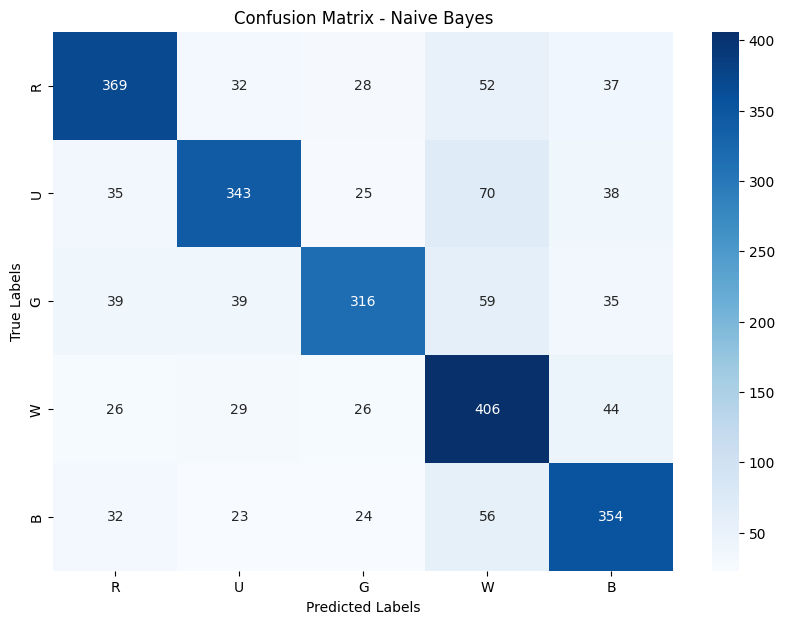

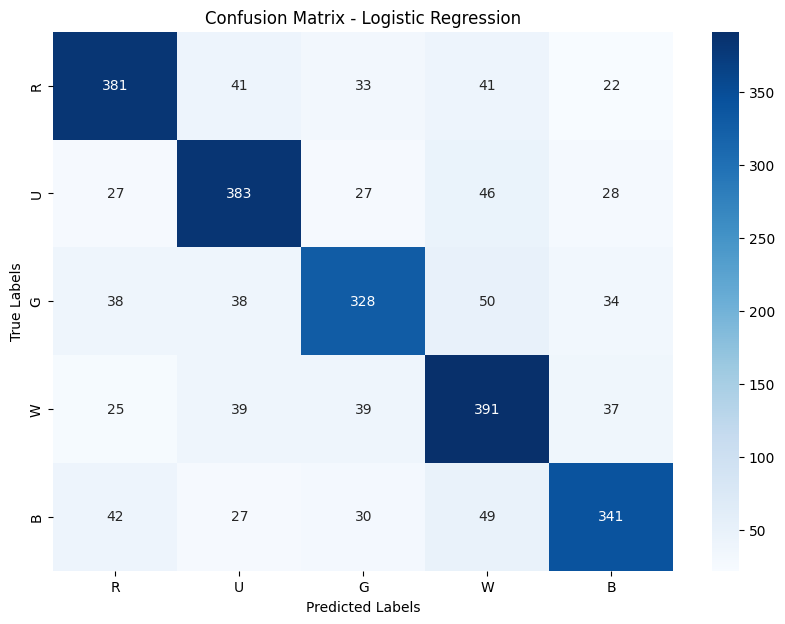

Model: TF-IDF + Naive Bayes
Accuracy: 0.70
Model: TF-IDF + Logistic Regression
Accuracy: 0.72

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           R       0.70      0.72      0.71       489
           U       0.75      0.65      0.70       488
           G       0.74      0.71      0.72       518
           W       0.74      0.67      0.70       511
           B       0.63      0.76      0.69       531

    accuracy                           0.70      2537
   macro avg       0.71      0.70      0.70      2537
weighted avg       0.71      0.70      0.70      2537


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           R       0.74      0.70      0.72       489
           U       0.72      0.67      0.69       488
           G       0.74      0.74      0.74       518
           W       0.73      0.75      0.74       511
           B       0.68      0.74      0.71       531

    accurac

In [157]:
train_texts = df_train['processed_flavor'].tolist() 
train_labels = df_train['color'].tolist() 

test_texts = df_test['processed_flavor'].tolist()  
test_labels = df_test['color'].tolist() 

#Vetorização dos textos com TF-IDF
vectorizer = CountVectorizer()
transformer = TfidfTransformer()

x_train_count = vectorizer.fit_transform(train_texts)
x_train_tfidf = transformer.fit_transform(x_train_count)

x_test_count = vectorizer.transform(test_texts)
x_test_tfidf = transformer.transform(x_test_count)

#print(x_train_tfidf)
#print('_____________')
#print(train_labels)
#print('_____________')
#print(x_test_tfidf)
#print('_____________')

#Naive Bayes e Regressão Logística
y_test_predict_nb = classify_NaiveBayesian(x_train_tfidf, train_labels, x_test_tfidf)
y_test_predict_lr = classify_Logistic(x_train_tfidf, train_labels, x_test_tfidf)

target_names = ['R', 'U', 'G', 'W', 'B']  

#Calcular a Confusion Matrix para Naive Bayes
cm_nb = confusion_matrix(test_labels, y_test_predict_nb, labels=target_names)
#Calcular a Confusion Matrix para Regressão Logística
cm_lr = confusion_matrix(test_labels, y_test_predict_lr, labels=target_names)

#Confusion Matrix para Naive Bayes
plt.figure(figsize=(10, 7))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Confusion Matrix para Regressão Logística
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Métricas de classificação para Naive Bayes e Regressão Logística
metrics_bow_nb = collect_classification_metrics(test_labels, y_test_predict_nb, model_name="TF-IDF + Naive Bayes", target_names=target_names)
report_nb = evaluation(y_test_predict_nb, test_labels, target_names=target_names)

metrics_bow_lr = collect_classification_metrics(test_labels, y_test_predict_lr, model_name="TF-IDF + Logistic Regression", target_names=target_names)
report_lr = evaluation(y_test_predict_lr, test_labels, target_names=target_names)

print("\nNaive Bayes Classification Report:")
print(report_nb)

print("\nLogistic Regression Classification Report:")
print(report_lr)

In [158]:
#textos classificados incorretamente para Naive Bayes
incorrect_nb_texts = []
incorrect_nb_true_labels = []
incorrect_nb_pred_labels = []

for text, true_label, pred_label in zip(test_texts, test_labels, y_test_predict_nb):
    if true_label != pred_label:
        incorrect_nb_texts.append(text)
        incorrect_nb_true_labels.append(true_label)
        incorrect_nb_pred_labels.append(pred_label)

#DataFrame para os erros do Naive Bayes
incorrect_nb = pd.DataFrame({
    'Text': incorrect_nb_texts,
    'True Label': incorrect_nb_true_labels,
    'Predicted Label': incorrect_nb_pred_labels
})

#textos classificados incorretamente para Regressão Logística
incorrect_lr_texts = []
incorrect_lr_true_labels = []
incorrect_lr_pred_labels = []

for text, true_label, pred_label in zip(test_texts, test_labels, y_test_predict_lr):
    if true_label != pred_label:
        incorrect_lr_texts.append(text)
        incorrect_lr_true_labels.append(true_label)
        incorrect_lr_pred_labels.append(pred_label)

#DataFrame para os erros da Regressão Logística
incorrect_lr = pd.DataFrame({
    'Text': incorrect_lr_texts,
    'True Label': incorrect_lr_true_labels,
    'Predicted Label': incorrect_lr_pred_labels
})


print("\nTextos classificados incorretamente pelo Naive Bayes:")
print(incorrect_nb)

print("\nTextos classificados incorretamente pela Regressão Logística:")
print(incorrect_lr)


Textos classificados incorretamente pelo Naive Bayes:
                                                  Text True Label  \
0    flying whenever cast kicked spell , scry 2 . `...          U   
1    additional cost cast spell , sacrifice creatur...          U   
2    flash enchant creature enchanted creature gets...          U   
3    : wily bandar gains indestructible end turn . ...          G   
4    heir ancient fang enters battlefield +1/+1 cou...          G   
5    whenever another creature control leaves battl...          W   
6    recruiter guard enters battlefield , may searc...          W   
7    flash enchantment enters battlefield , may put...          U   
8    whenever crashing boars attacks , defending pl...          G   
9    : creatures control get +1/+1 end turn . `` Th...          W   
10   destroy creatures , create x/x colorless phyre...          W   
11   deathtouch guildsworn prowler dies , n't block...          B   
12   exchange control target land control target

# REDE NEURONAL

C:\Users\David Isaac\OneDrive - ISCTE-IUL\Ambiente de Trabalho\3_Ano_IA\text_mining\projeto_text_magic\ml_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


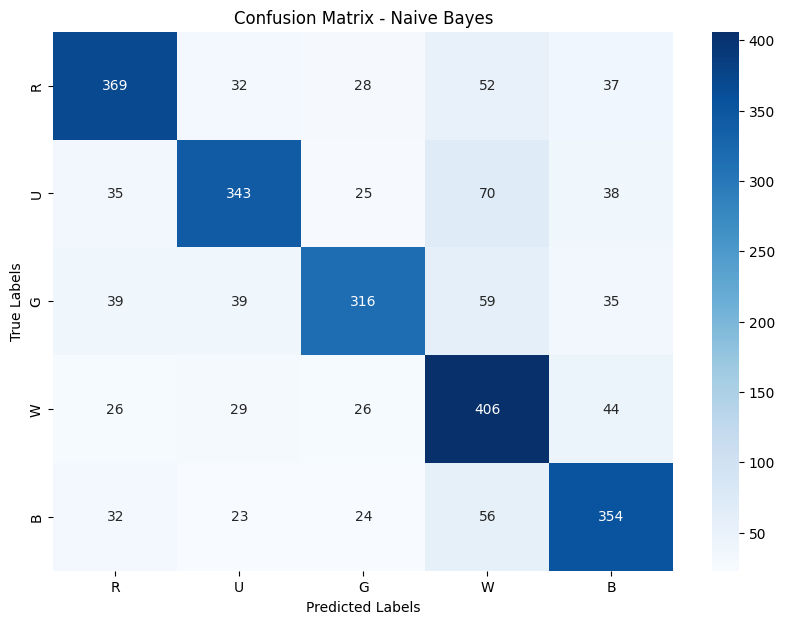

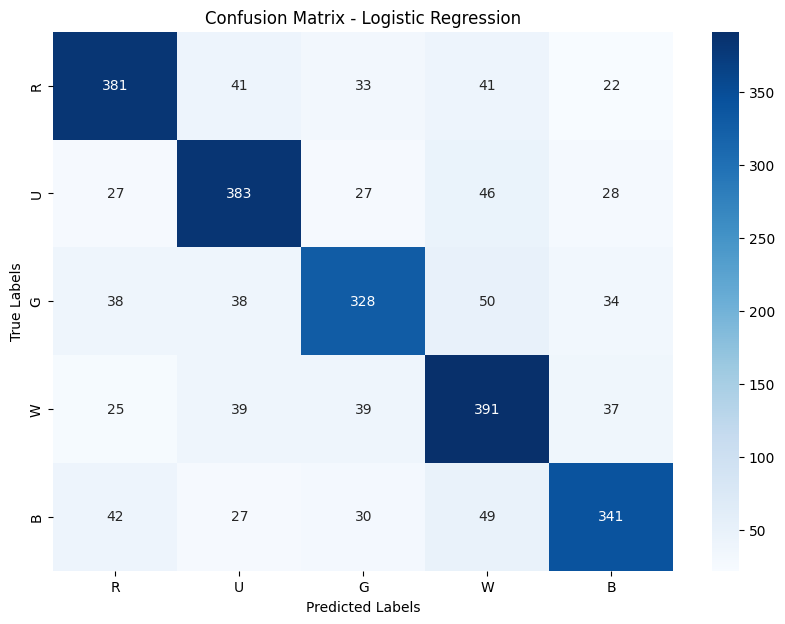

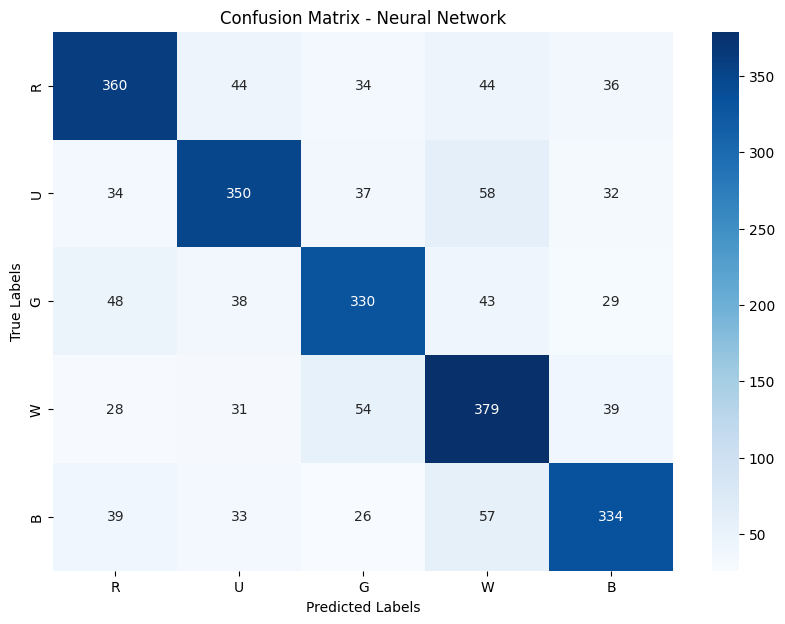

Model: TF-IDF + Naive Bayes
Accuracy: 0.70
Model: TF-IDF + Logistic Regression
Accuracy: 0.72
Model: TF-IDF + Neural Network
Accuracy: 0.69

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           R       0.70      0.72      0.71       489
           U       0.75      0.65      0.70       488
           G       0.74      0.71      0.72       518
           W       0.74      0.67      0.70       511
           B       0.63      0.76      0.69       531

    accuracy                           0.70      2537
   macro avg       0.71      0.70      0.70      2537
weighted avg       0.71      0.70      0.70      2537


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           R       0.74      0.70      0.72       489
           U       0.72      0.67      0.69       488
           G       0.74      0.74      0.74       518
           W       0.73      0.75      0.74       511
           B       0

In [170]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

train_texts = df_train['processed_flavor'].tolist() 
train_labels = df_train['color'].tolist() 

test_texts = df_test['processed_flavor'].tolist()  
test_labels = df_test['color'].tolist() 

# Vetorização dos textos com TF-IDF
vectorizer = CountVectorizer()
transformer = TfidfTransformer()

x_train_count = vectorizer.fit_transform(train_texts)
x_train_tfidf = transformer.fit_transform(x_train_count)

x_test_count = vectorizer.transform(test_texts)
x_test_tfidf = transformer.transform(x_test_count)

# Naive Bayes, Regressão Logística e Rede Neuronal
y_test_predict_nb = classify_NaiveBayesian(x_train_tfidf, train_labels, x_test_tfidf)
y_test_predict_lr = classify_Logistic(x_train_tfidf, train_labels, x_test_tfidf)

# Rede Neuronal (MLP)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(x_train_tfidf, train_labels)
y_test_predict_mlp = mlp_model.predict(x_test_tfidf)

target_names = ['R', 'U', 'G', 'W', 'B']  

# Calcular a Confusion Matrix para Naive Bayes, Regressão Logística e Rede Neuronal
cm_nb = confusion_matrix(test_labels, y_test_predict_nb, labels=target_names)
cm_lr = confusion_matrix(test_labels, y_test_predict_lr, labels=target_names)
cm_mlp = confusion_matrix(test_labels, y_test_predict_mlp, labels=target_names)

# Confusion Matrix para Naive Bayes
plt.figure(figsize=(10, 7))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Confusion Matrix para Regressão Logística
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Confusion Matrix para Rede Neuronal
plt.figure(figsize=(10, 7))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Neural Network")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Métricas de classificação para Naive Bayes, Regressão Logística e Rede Neuronal
metrics_bow_nb = collect_classification_metrics(test_labels, y_test_predict_nb, model_name="TF-IDF + Naive Bayes", target_names=target_names)
report_nb = evaluation(y_test_predict_nb, test_labels, target_names=target_names)

metrics_bow_lr = collect_classification_metrics(test_labels, y_test_predict_lr, model_name="TF-IDF + Logistic Regression", target_names=target_names)
report_lr = evaluation(y_test_predict_lr, test_labels, target_names=target_names)

metrics_bow_mlp = collect_classification_metrics(test_labels, y_test_predict_mlp, model_name="TF-IDF + Neural Network", target_names=target_names)
report_mlp = evaluation(y_test_predict_mlp, test_labels, target_names=target_names)

print("\nNaive Bayes Classification Report:")
print(report_nb)

print("\nLogistic Regression Classification Report:")
print(report_lr)

print("\nNeural Network Classification Report:")
print(report_mlp)


# PREVISOES COM FEATURES

In [159]:
df_prever = df.copy()

In [160]:
df_prever.columns

Index(['Unnamed: 0', 'name', 'multiverse_id', 'text', 'flavor', 'power',
       'color', 'counterspell', 'exile', 'fight', 'mill', 'scry', 'tap',
       'untap', 'double_strike', 'first_strike', 'flash', 'flying', 'haste',
       'hexproof', 'indestructible', 'sacrifice', 'lifelink', 'menace',
       'protection', 'prowess', 'reach', 'trample', 'vigilance', 'draw',
       'discard', 'damage', 'damage_prevention', 'life_gain', 'life_loss',
       'tokens', 'destroy', 'return', 'recursion', 'all_Text',
       'processed_flavor'],
      dtype='object')

In [161]:
df_prever = df_prever.drop(columns=['Unnamed: 0', 'multiverse_id','text','flavor','processed_flavor','name'])

In [162]:
df_prever.isnull().sum()

power                5310
color                   0
counterspell            0
exile                   0
fight                 289
mill                  289
scry                  289
tap                   289
untap                 289
double_strike         289
first_strike          289
flash                   0
flying                289
haste                 289
hexproof              289
indestructible          0
sacrifice             289
lifelink              289
menace                289
protection            289
prowess               289
reach                   0
trample               289
vigilance             289
draw                  289
discard               289
damage                289
damage_prevention     289
life_gain             289
life_loss               0
tokens                289
destroy                 0
return                  0
recursion               0
all_Text                0
dtype: int64

In [163]:
df_prever = df_prever.dropna() 

In [164]:
# Convertendo colunas booleanas em 0 e 1
boolean_columns = ['counterspell', 'exile', 'fight', 'mill', 'scry', 'tap', 'untap', 
                   'double_strike', 'first_strike', 'flash', 'flying', 'haste', 'hexproof', 
                   'indestructible', 'sacrifice', 'lifelink', 'menace', 'protection', 'prowess', 
                   'reach', 'trample', 'vigilance', 'draw', 'discard', 'damage', 'damage_prevention', 
                   'life_gain', 'life_loss', 'tokens', 'destroy', 'return', 'recursion','all_Text']

# Convertendo as colunas booleanas para inteiros (0 ou 1)
df_prever[boolean_columns] = df_prever[boolean_columns].astype(int)

# Mapeando as cores para números
color_mapping = {
    'G': 1,  # Verde
    'R': 2,  # Vermelho
    'U': 3,  # Azul
    'W': 4,  # Branco
    'B': 5   # Preto
}

# Aplicando o mapeamento à coluna 'color'
df_prever['color'] = df_prever['color'].map(color_mapping)
# Caso a coluna 'color' tenha valores ausentes ou errados, podemos tratar com um valor padrão, por exemplo, 0
df_prever['color'] = df_prever['color'].fillna(0).astype(int)

# Tratando a coluna 'power' (convertendo para float, se necessário)
# Se a coluna 'power' contiver valores de texto como '*', podemos substituir por NaN antes da conversão
df_prever['power'] = pd.to_numeric(df_prever['power'], errors='coerce')

# Verificando o resultado
print(df_prever.head())

ValueError: invalid literal for int() with base 10: 'first strike \r\nwhen ancestor\'s chosen enters the battlefield, you gain 1 life for each card in your graveyard. "The will of all, by my hand done."'

In [ ]:
df_prever.columns

In [ ]:
print(df_prever.dtypes)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecionar colunas relevantes
selected_columns = ['color', 'counterspell', 'flying', 'haste', 'hexproof', 'indestructible', 
                    'lifelink', 'menace', 'protection', 'trample', 'vigilance', 'damage']

# Subset do DataFrame com as colunas selecionadas
df_selected = df_prever

# Calcular a matriz de correlação
correlation_matrix = df_selected.corr()

# Focar apenas nas correlações da variável `color` com as outras
color_correlation = correlation_matrix.loc[['color'], correlation_matrix.columns != 'color']

# Criar o heatmap
plt.figure(figsize=(20, 10))  # Tamanho ajustado para o gráfico horizontal
sns.heatmap(color_correlation, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, cbar_kws={'orientation': 'horizontal'})
plt.title('Correlação da Cor com Outras Variáveis', fontsize=14)
plt.xlabel('Variáveis')
plt.ylabel('Cor')
plt.show()



In [ ]:
df_prever_ml = df_prever[['exile', 'flying', 'lifelink', 'life_loss','color']]

In [ ]:
from sklearn.model_selection import train_test_split

X = df_prever_ml.drop('color', axis=1)  # Atributos
y = df_prever_ml['color']  # Alvo (cor da carta)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# WORLD CLOUD

In [ ]:
# Função para gerar o WordCloud para uma cor específica
def gerar_wordcloud_cor(cor, df):
    # Filtra as linhas onde a coluna 'color' contém a cor desejada
    filtered_words = df[df['color'].str.contains(cor, case=False, na=False)]['processed_flavor']

    # Cria uma string com todas as palavras filtradas
    comment_words = ' '.join(filtered_words)

    # Verifica se há palavras filtradas antes de gerar o WordCloud
    if comment_words:
        # Gerar o WordCloud com o texto filtrado
        wordcloud = WordCloud(width=800, height=800,
                              background_color='white',
                              stopwords=STOPWORDS,
                              min_font_size=10).generate(comment_words)

        # Exibe a imagem do WordCloud para a cor
        plt.figure(figsize=(8, 8), facecolor=None)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.tight_layout(pad=0)

        # Adiciona título com o nome da cor
        plt.title(f"WordCloud para a cor: {cor}", fontsize=16)
        plt.show()
    else:
        print(f"Não há palavras associadas à cor: {cor}")

# Escolha a cor desejada para o WordCloud
cor_escolhida = 'R'  # Exemplo: 'red', pode substituir por qualquer cor

# Chama a função para gerar o WordCloud para a cor escolhida
gerar_wordcloud_cor(cor_escolhida, df)
